In [1]:
import pandas as pd
import numpy as np
import math
#from datetime import date, datetime, timedelta # to manipulate dates

from pylab import savefig
from __future__ import division
import statistics
from datetime import datetime
% matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context(context='notebook', font_scale=1.5, rc=None)

path='/Users/brianna/Documents/WL_DBdeets/'

In [2]:
def makeDFsubset(df, varListOneNumber, varListByWeek):
    # Not Including: 
    # added_noteWeek0 - stopped being collected in September
    # viewed_onboarding__tour_4_pageWeek - only collected starting in September
    
    # Expand varListByWeek to grab both Week0 and Week1 variables
    varListByWeekExpanded = []
    for v in varListByWeek:
        varListByWeekExpanded.append(v+'Week0')
        varListByWeekExpanded.append(v+'Week1')
     
    # Take just the variables that you want to look at later.
    df = df.loc[:,varListOneNumber + varListByWeekExpanded]
    
    # Make this EmailCorporateVsPrivate variable, which is .5 for corporate
    # and -.5 for school or personal email accounts.
    df['EmailCorporateVsPrivate']=0
    corpEmail = df.emailDomain == 'company'
    personalEmail = df['emailDomain'] == 'personal'
    schoolEmail = df['emailDomain'] == 'school'
    df.loc[corpEmail,'EmailCorporateVsPrivate'] = .5
    df.loc[personalEmail,'EmailCorporateVsPrivate'] = -.5
    df.loc[schoolEmail,'EmailCorporateVsPrivate'] = -.5
    
    # Add another variable called completed_WL_action which sums over all
    # WL actions I collected.
    df['completed_WL_actionWeek0'] = df.added_meetingWeek0 + df.added_agenda_itemWeek0 + df.assigned_action_itemWeek0
    df['completed_WL_actionWeek1'] = df.added_meetingWeek1 + df.added_agenda_itemWeek1 + df.assigned_action_itemWeek1
    varListByWeek.append('completed_WL_action')

    # Make a dummy variable of 1's in case we need it later when we try to sum things.
    df['dummy'] = 1
    
    return df, varListByWeek, varListByWeekExpanded

In [3]:
# Calculate the difference in events from week X to week Y, then drop the variables
# for the individual weeks 0 and 1 from the dataframe.
def calculateWeekX_YDiff(df, varListByWeek, X, Y):
    varListByWeekNew = []
    #varListDrop = []
    for v in varListByWeek:
        df[v+str(Y)+'plus'+str(X)]=(df[v+'Week'+str(Y)]+df[v+'Week'+str(X)])/2
        df[v+str(Y)+'minus'+str(X)]=df[v+'Week'+str(Y)]-df[v+'Week'+str(X)] 
        varListByWeekNew.append(v+str(Y)+'plus'+str(X))
        varListByWeekNew.append(v+str(Y)+'minus'+str(X))
        #varListDrop.append(v+'Week'+str(X))
        #varListDrop.append(v+'Week'+str(Y))
        
    #df = df.drop(varListDrop, axis=1)
    # Add the newly calculated variables to the 
    return df, varListByWeekNew

In [4]:
def pullInOutliers(df, varListContinuous, numStdDev):
    for v in varListContinuous:
        #print(v)
        varUpperLimit = np.mean(df[v]) + numStdDev*np.std(df[v])
        varLowerLimit = np.mean(df[v]) - numStdDev*np.std(df[v])
        
        #(df[v] > varMean - 5*varStdDev) and 
        #print(str(varUpperLimit)+', '+str(varLowerLimit))
        #df.loc[df[v] > varUpperLimit, v] = varUpperLimit
        #df.loc[df[v] < varLowerLimit, v] = varLowerLimit
        df.loc[df[v] > varUpperLimit, v] = None
        df.loc[df[v] < varLowerLimit, v] = None
        
    return df

In [5]:
def imputeVars(df, varListContinuous, pctCutOff):    
    varListContinuousNew = varListContinuous[:]
    for v in varListContinuous:
        totMissing = len(df.loc[df[v].isnull(),v])
        totUser = len(df[v])
        pctMissing = totMissing/totUser
        print(v+': '+str(pctMissing))
        # If less than X% of data (pctCutOff) is missing, replace missing data with the median of the data
        # Append a '_i' on the end of the variable so you know it's been imputed.
        if pctMissing < pctCutOff:
            df[v+'_i']=df[v][:]
            #df.loc[df[v+'_i'].isnull(),v+'_i']=np.mean(df[v])
            df.loc[df[v+'_i'].isnull(),v+'_i']=statistics.median(df[v])
            varListContinuousNew.append(v+'_i')
            
    return df, varListContinuousNew

In [6]:
def logTransformVars(df, varListContinuous):    
    logVars = []
    for v in varListContinuous:
        if '1minus0' not in v:
            df[v+'_log']=df[v].apply(lambda x : math.log(x+1.0))
            #df[v+'_log']=math.log(df[v][:]+1.0)
            logVars.append(v+'_log')
            #print(v+'_log')
    
    varListContinuous += logVars
    
    return df, varListContinuous

In [7]:
def plotCorrMatrix(df, varList, nameAppend):
    
    df=df.loc[:,varList]
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()
    #print(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
    savefig(path+'images/correlationMatrix'+nameAppend+'.jpg')

In [8]:
def plotVarHist(df, variableName):
 
    plt.figure(figsize=(20,10))
    #df[variableName].hist(bins = len(df[variableName].unique()))
    df[variableName].hist()

    plt.xlabel(variableName, size=20)
    plt.ylabel('Count', size = 20)
    plt.savefig(path+'images/'+variableName+'Histogram.jpg')

In [9]:
def plotVarByWeek(df, variableName):
    plt.figure(figsize=(15,15))
    sums = df.groupby('registrationWeek')[variableName].sum()
    #print(sums.index[:5])
    #print(sums[:5])
    #plt.bar(df['registrationWeek'], df[variableName])
    
    sns.set()
    sns.set_style("whitegrid")
    ax = sns.barplot(x=sums.index, y=sums, label = 'medium', color='blue')
    ax.set(xlabel='Week', ylabel='Instances of '+variableName)
    
    for item in ax.get_xticklabels():
        item.set_rotation(45)
        
    #ax.savefig(path+variableName+'.png')

# Main Function

In [10]:
# Make List of variables and take a subset of df with just these variables.
varListCategorical = ['user_id', 
                      'registrationWeek',
                      'sharedEmail',
                      'emailDomain']
varListOther = ['NumberSignedUpFromCompany']

varListByWeek =  ['MeetingsTotal',
                  'organizerTotal',
                  'PortionOfOrganizer',
                  'num_attendees',
                  'AveNumAttendees', 
                  'added_meeting',
                  'added_agenda_item',
                  'assigned_action_item']

varListRetention = ['RetentionStatus2Levels',
                    'RetentionStatus4Levels',
                    'WeeksVisitedOutOf12']

varListOneNumber = varListCategorical + varListOther + varListRetention

In [11]:
# Read in the dataframe with all of the variables of interest.
df = pd.read_csv(path+'05_RetentionMeetingsBehaviorFull.csv')

# First, remove any data before July 1 (or June 28, since that's the nearest cohort).  
# Val isn't sure if we can trust anything before that because they were still figuring 
# out the data collection.
x = df[(df.registrationWeek !='2015-05-24') &
       (df.registrationWeek !='2015-05-31') &
       (df.registrationWeek !='2015-06-07') &
       (df.registrationWeek !='2015-06-14') &
       (df.registrationWeek !='2015-06-21')]

print(len(x))
print(len(df))

7493
9005


In [12]:
# Now take a subset of the dataframe with just the variables that we're interested in.
df, varListByWeek, varListByWeekExpanded = makeDFsubset(df, varListOneNumber, varListByWeek)

In [13]:
varListByWeek

['MeetingsTotal',
 'organizerTotal',
 'PortionOfOrganizer',
 'num_attendees',
 'AveNumAttendees',
 'added_meeting',
 'added_agenda_item',
 'assigned_action_item',
 'completed_WL_action']

In [14]:
# Calculate the events velocity (difference in events from Week0 to Week1)
df, varListByWeek = calculateWeekX_YDiff(df, varListByWeek, 0, 1)

In [15]:
# If there are extreme values (ie. greater than 4 sd from the mean), pull them
# in to 4 sd from the mean.
varListContinuous = varListOther + varListByWeek + varListByWeekExpanded
df = pullInOutliers(df, varListContinuous, 3)

In [16]:
# If less than 31% of data is missing, make a variable with imputations on missing values.
df, varListContinuous = imputeVars(df, varListContinuous, .31)

NumberSignedUpFromCompany: 0.302498611882
MeetingsTotal1plus0: 0.307495835647
MeetingsTotal1minus0: 0.315824541921
organizerTotal1plus0: 0.319156024431
organizerTotal1minus0: 0.316935036091
PortionOfOrganizer1plus0: 0.314825097168
PortionOfOrganizer1minus0: 0.318933925597
num_attendees1plus0: 0.309272626319
num_attendees1minus0: 0.317934480844
AveNumAttendees1plus0: 0.31549139367
AveNumAttendees1minus0: 0.316935036091
added_meeting1plus0: 0.0166574125486
added_meeting1minus0: 0.00977234869517
added_agenda_item1plus0: 0.0152137701277
added_agenda_item1minus0: 0.0151027207107
assigned_action_item1plus0: 0.0154358689617
assigned_action_item1minus0: 0.0185452526374
completed_WL_action1plus0: 0.0153248195447
completed_WL_action1minus0: 0.0152137701277
MeetingsTotalWeek0: 0.248528595225
MeetingsTotalWeek1: 0.273625763465
organizerTotalWeek0: 0.259300388673
organizerTotalWeek1: 0.284952803998
PortionOfOrganizerWeek0: 0.270516379789
PortionOfOrganizerWeek1: 0.271182676291
num_attendeesWeek0: 0

In [17]:
# Make log-transformed variables of the continuous variables since they're all super skewed.
df, varListContinuous = logTransformVars(df, varListContinuous)

In [18]:
# Get a list of the variables that were both imputed and log-transformed.
varsOfInterest = []
for v in varListContinuous:
    if 'Week0_i_log' in v:
        varsOfInterest.append(v)
print(varsOfInterest)

['MeetingsTotalWeek0_i_log', 'organizerTotalWeek0_i_log', 'PortionOfOrganizerWeek0_i_log', 'num_attendeesWeek0_i_log', 'AveNumAttendeesWeek0_i_log', 'added_meetingWeek0_i_log', 'added_agenda_itemWeek0_i_log', 'assigned_action_itemWeek0_i_log']


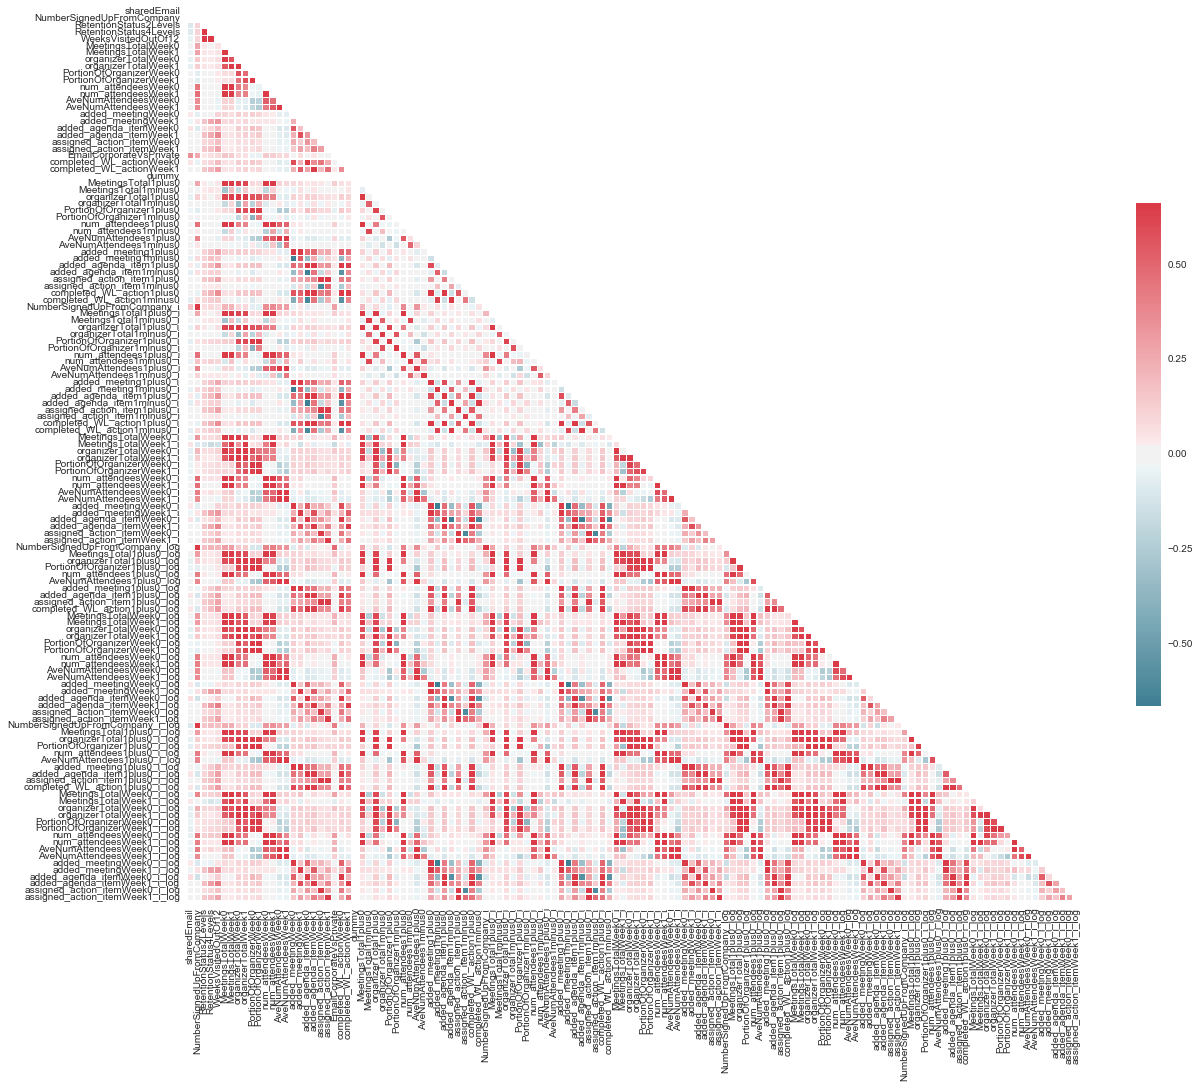

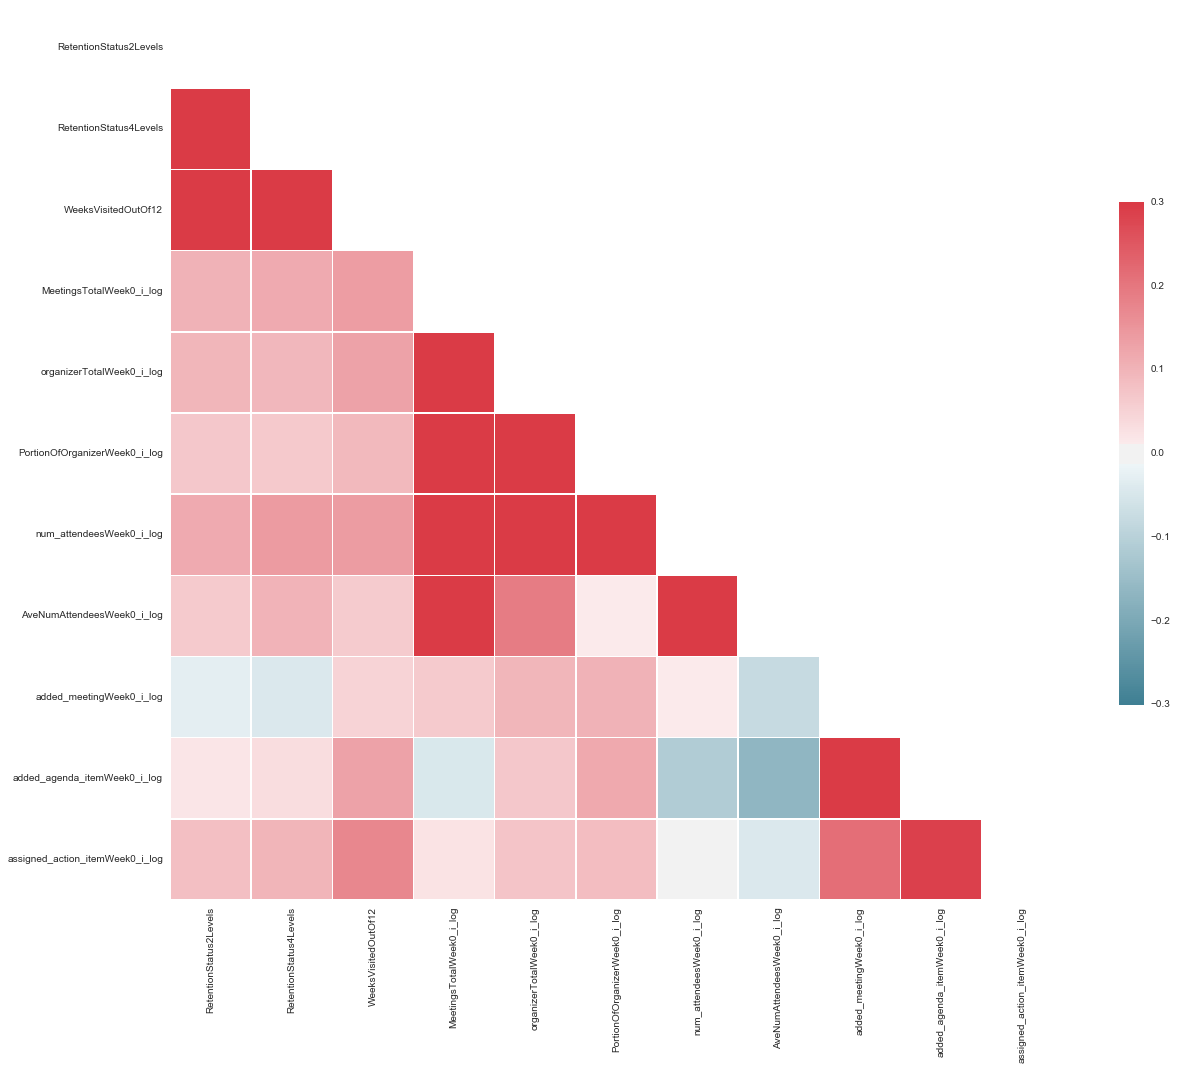

In [25]:
#Plot the correlation matrix (for all variables, then just our nice imputed, log-transformed ones)
plotCorrMatrix(df, df.columns, 'allVars')
plotCorrMatrix(df, varListRetention+varsOfInterest, 'varsOfInterestImputedLogTransformed')

In [ ]:
for v in varListContinuous:
    plotVarHist(df,v)
    #plotVarByWeek(df, v)

In [ ]:
for v in varListContinuous:
    plotVarByWeek(df, v)

In [19]:
df.to_csv(path+'06_DataFinal3SDRemoved.csv')